## 데이터셋 구경

In [1]:
import pandas as pd

df=pd.read_csv('data/metadata_with_Nan.csv')

filter = df[df['Shape_Feature'].isin(['C '])]

filter

,Name,Upper,Category,Shape_Feature,Description
12,BL-001,T,BL,C,스카이 블루 페일 톤 단색
29,BL-002,T,BL,C,아이보리 단색
51,BL-003,T,BL,C,화이트 단색
74,BL-004,T,BL,C,화이트 단색
92,BL-005,T,BL,C,화이트 단색
...,...,...,...,...,...
116967,VT-272,O,VT,C,아이보리 단색
116968,VT-272,O,VT,C,상의 가슴 부분 왼쪽 브라운 대비 색 포인트 배색
116969,VT-272,O,VT,C,상의 암홀 부분 브라운 대비 색 포인트 배색
116970,VT-272,O,VT,C,상의 앞 중심선 부분 오른쪽 브라운 대비 색 포인트 배색


## Feature Extraction - Clustering

In [1]:
import pandas as pd
from torch.utils.data import DataLoader

df=pd.read_csv('data/metadata_with_Nan.csv') # read csv
names = set(list(df['Name'])) # remove duplicates
names = pd.DataFrame(names, columns=['Name']) # column name add

In [2]:
from tools.Fashiondataset import FashionDataset

image_folder = 'data/img_jpg' # set path
Dataset=FashionDataset(dataframe=names, image_folder=image_folder) # load unchange dataset
Dataloader=DataLoader(Dataset, batch_size=16, shuffle=False) # make dataloader

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image
from tools.ExtractFeature import extract_features_from_images, get_features
from tools.clustering import perform_clustering_with_cache
import numpy as np

사용하는 장치: cuda


In [102]:
user_name='default' # set name for various user
model = 'deit' # ['resnet', 'vit', 'dino', 'deit']
no_clusters=16 # set cluster number
force_ex = False # force to run and save model and features again

features = get_features(user_name, model, Dataloader, force_extract=force_ex) # extract features from model and save numpy

deit extracted feature load from saved/default_features_deit.npy.


## Bagging

In [103]:
"""dic={} # keeping data
for i in ['resnet', 'vit', 'dino', 'deit']: # set models
    temp=[]
    for j in range(5): # run 5 times
        temp.append(get_features(user_name+f'{j}', i, Dataloader, force_extract=True))

    dic[i]=temp"""

"dic={} # keeping data\nfor i in ['resnet', 'vit', 'dino', 'deit']: # set models\n    temp=[]\n    for j in range(5): # run 5 times\n        temp.append(get_features(user_name+f'{j}', i, Dataloader, force_extract=True))\n\n    dic[i]=temp"

In [104]:
"""for i in ['resnet', 'vit', 'dino', 'deit']: # bagging with arithmetic mean
    bagged_features = sum(dic[i])/5
    np.save(f'saved/{user_name}_bagged_{i}_feature.npy',bagged_features) # save bagged data
    print('done')"""

"for i in ['resnet', 'vit', 'dino', 'deit']: # bagging with arithmetic mean\n    bagged_features = sum(dic[i])/5\n    np.save(f'saved/{user_name}_bagged_{i}_feature.npy',bagged_features) # save bagged data\n    print('done')"

In [105]:
features = np.load(f'saved/default_bagged_{model}_feature.npy') # load saved data

In [107]:
# perform clustering and save model
labels, kmeans = perform_clustering_with_cache(user_name, features, model_type=model, n_clusters=no_clusters, force_cluster=False)

default clustered labels were load from saved/default_labels_deit_16clusters.npy.
모델을 불러왔습니다: saved/default_deit_16clusters_model.pkl


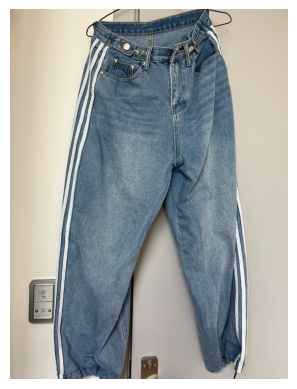

In [108]:
img_path = 'data/preference/PT1.jpg' # load sample input image
image = Image.open(img_path).convert('RGB')
plt.imshow(image) # show image
plt.axis('off') 
plt.show()

In [109]:
from tools.Extractor import FeatureExtractor
import torch
import warnings

warnings.filterwarnings('ignore', category=UserWarning) # erase warning

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device with gpu
# extract feature from input image
image_features = extract_features_from_images([img_path], FeatureExtractor(model_type=model).to(device), device, transform=True)
print(features.shape)
print(image_features.shape)
warnings.resetwarnings()

Feature extraction: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s]

(7197, 768)
(1, 768)


## Category classification

In [110]:
print("Labels loaded:", labels is not None)
print("Model loaded:", kmeans is not None)

if kmeans is not None:
    predicted_cluster = kmeans.predict(image_features)[0] # predict input image
    print(f"이 이미지는 군집 {predicted_cluster}에 속합니다")
else:
    print("모델이 로드되지 않았습니다. force_cluster=True로 다시 시도합니다.")
    labels, kmeans = perform_clustering_with_cache(user_name, features, model_type=model, n_clusters=no_clusters, force_cluster=True)
    predicted_cluster = kmeans.predict(image_features)[0]
    print(f"이 이미지는 군집 {predicted_cluster}에 속합니다")

Labels loaded: True
Model loaded: True
이 이미지는 군집 2에 속합니다


군집 2에 속한 이미지들:
Image name: PT-208
Image name: PT-681
Image name: PT-383
Image name: PT-701
Image name: PT-677


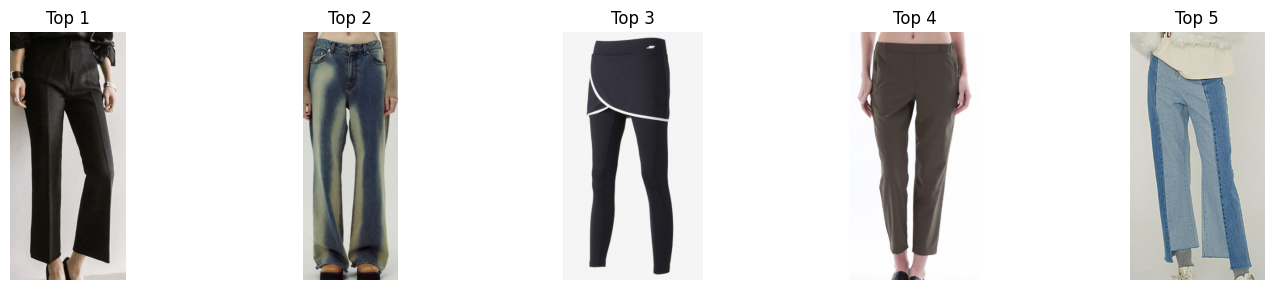

In [111]:
import numpy as np
from tools.clustering import show_cluster_images

# find the same clustered images from input image
show_cluster_images(Dataset, labels, cluster_num=predicted_cluster, num_samples=5)

In [112]:
from tools.clustering import get_cluster_categories

# map category symbols to category name
category_mapping = {'JK': 'Jacket', 'CT': 'Coat', 'JP': 'Jumper', 'KN': 'Knit', 'SW': 'Sweater', 'SH': 'Shirt', 'BL': 'Blouse', 'CD': 'Cardigan', 'VT': 'Vest', 'OP': 'One Piece', 'SK': 'Skirt', 'PT': 'Pants', 'SE': 'Shoes', 'BG': 'Bag', 'SC': 'Scarf', 'HC': 'Hat & Cap'}

cluster_categories = get_cluster_categories(Dataset, kmeans, features, labels)
# match cluster number with category name
cluster_names = {k: category_mapping.get(v, 'Unknown') for k, v in cluster_categories.items()}
print(cluster_names)

{np.int32(0): 'Skirt', np.int32(1): 'Coat', np.int32(2): 'Pants', np.int32(3): 'Shoes', np.int32(4): 'One Piece', np.int32(5): 'Scarf', np.int32(6): 'Shirt', np.int32(7): 'Sweater', np.int32(8): 'Hat & Cap', np.int32(9): 'Coat', np.int32(10): 'Jumper', np.int32(11): 'Bag', np.int32(12): 'One Piece', np.int32(13): 'Bag', np.int32(14): 'Hat & Cap', np.int32(15): 'Shirt'}


## Similarity check

In [113]:
from tools.similarity2 import Similarity

# set similarity vector field
sim = Similarity(
    feature_vectors=features,
    dataset=Dataset,
    user_name=user_name,
    model_type=model,
    force_new=False
)

Saved index and vectors for user default
Saved new features for default



추천 결과:
4개의 유사도가 높은 아이템이 있습니다.

상위 5개 아이템 유사도:
1번째 아이템: 70.58999633789062%
2번째 아이템: 69.97000122070312%
3번째 아이템: 68.30000305175781%
4번째 아이템: 68.18000030517578%
5번째 아이템: 66.58000183105469%


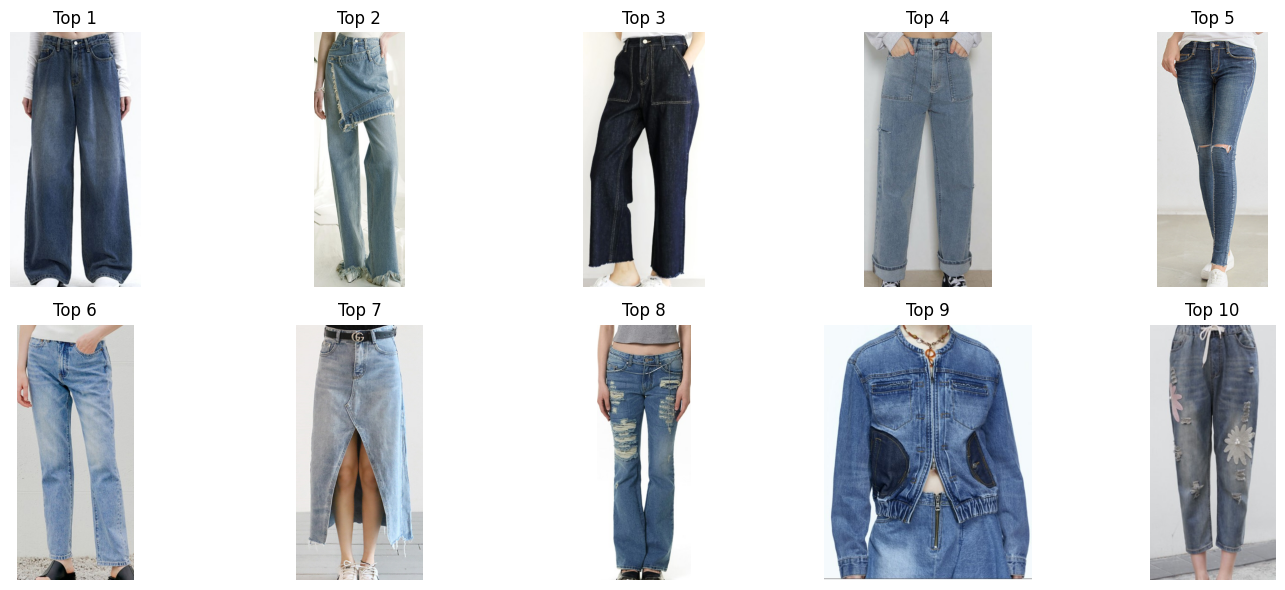

In [114]:
# find similarity top 10
a=sim.get_sim(image_features, k=10)[0]
# check buying attractiveness
percentages, recommendation = sim.attractiveness(image_features, return_percentage=True, custom_threshold=None)

print("\n추천 결과:")
print(recommendation)

print("\n상위 5개 아이템 유사도:")
for i, percent in enumerate(percentages[0][:5], 1):
    print(f"{i}번째 아이템: {percent}%")
Dataset.show_images(a)

## Check clustering

In [115]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

# visualise PCA and scree plot
def visualize_in_3d_with_scree_plot(features, labels):
    pca_full = PCA().fit(features) # PCA perform
    explained_variance = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
    n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
    n_components_70 = np.argmax(cumulative_variance >= 0.7) + 1
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.grid()
    
    plt.axvline(x=n_components_90, color='red', linestyle='--', label=f'90% Variance at PC {n_components_90}')
    plt.axvline(x=n_components_80, color='green', linestyle='--', label=f'80% Variance at PC {n_components_80}')
    plt.axvline(x=n_components_70, color='blue', linestyle='--', label=f'70% Variance at PC {n_components_70}')
    plt.legend()
    plt.show()
    
    pca = PCA(n_components=3) # filter 3 components
    features_3d = pca.fit_transform(features)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], 
                         c=labels, cmap='tab20c', s=15)
    
    ax.set_title('Clustered Feature 3D Visualization')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    
    legend = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend)
    
    plt.show()

# check elbow point
def find_optimal_clusters(features, max_clusters=30, plot=True):
    inertias = []
    K = range(10, max_clusters + 1)
    
    for k in K:
        print(f"Testing k={k}")
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)
        inertias.append(kmeans.inertia_)
    
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(K, inertias, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True)
        plt.show()
    
    kn = KneeLocator(
        K, 
        inertias,
        curve='convex',
        direction='decreasing'
    )
    optimal_k = kn.elbow
    
    print(f"최적의 클러스터 수: {optimal_k}")
    return optimal_k

### Elbow point

Testing k=10
Testing k=11
Testing k=12
Testing k=13
Testing k=14
Testing k=15
Testing k=16
Testing k=17
Testing k=18
Testing k=19
Testing k=20
Testing k=21
Testing k=22
Testing k=23
Testing k=24
Testing k=25
Testing k=26
Testing k=27
Testing k=28
Testing k=29
Testing k=30


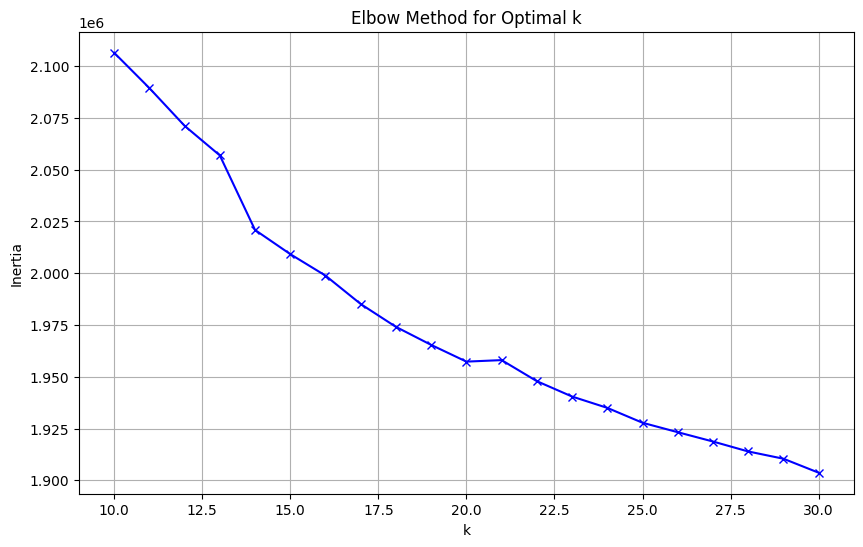

최적의 클러스터 수: 18


In [116]:
optimal_k = find_optimal_clusters(features)

### Scree plot with PCA analysis

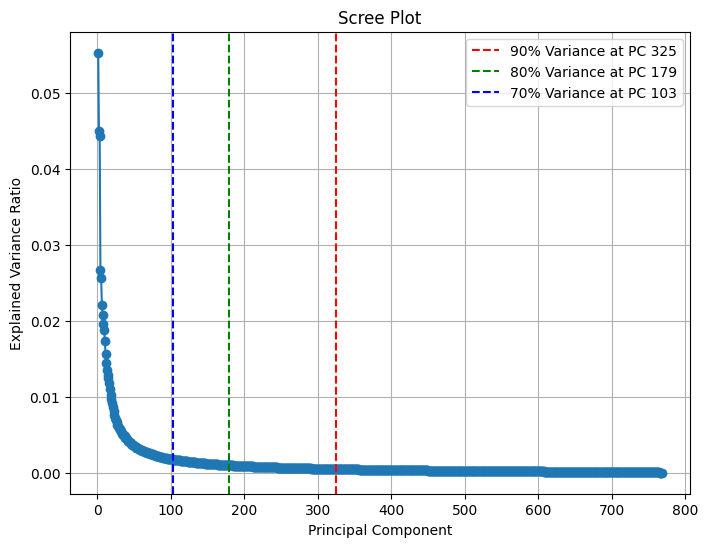

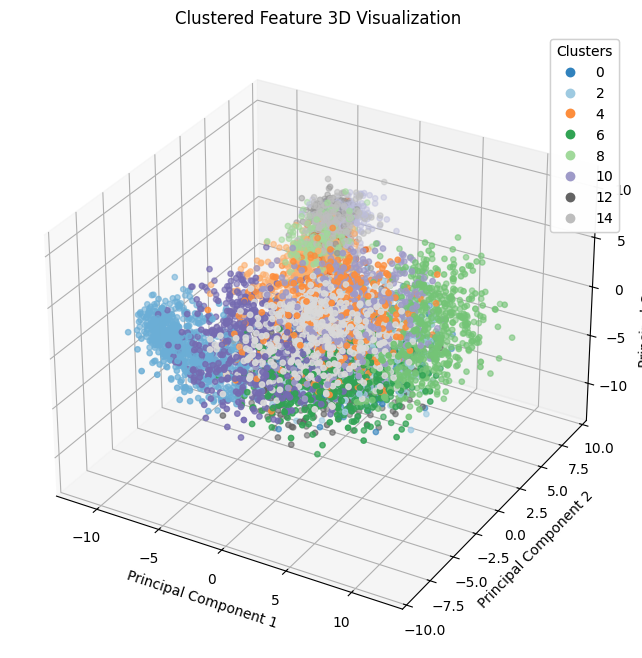

In [117]:
visualize_in_3d_with_scree_plot(features,labels)

## Recommend coordination

In [118]:
import os
from pathlib import Path

# get image paths for brand identity
def get_image_paths(folder_path, recursive=False):
    IMAGE_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp')
    
    image_paths = []
    
    folder = Path(folder_path)
    
    if not folder.exists():
        raise FileNotFoundError(f"폴더를 찾을 수 없습니다: {folder_path}")
    
    pattern = "**/*" if recursive else "*"
    
    for file_path in folder.glob(pattern):
        if file_path.is_file() and file_path.suffix.lower() in IMAGE_EXTENSIONS:
            image_paths.append(str(file_path))
    
    return sorted(image_paths) 

In [119]:
# feature extract from brand identity images

warnings.filterwarnings('ignore', category=UserWarning)

img_path = get_image_paths("data/Maje")
features = get_features(user_name, model, Dataloader, force_extract=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
maje_features = extract_features_from_images(img_path, FeatureExtractor(model_type=model).to(device), device, transform=True)

warnings.resetwarnings()

deit extracted feature load from saved/default_features_deit.npy.


Feature extraction: 100%|██████████| 18/18 [00:00<00:00, 43.26it/s]


In [120]:
# category check from clustering
labels, kmeans = perform_clustering_with_cache(user_name, features, model_type=model, n_clusters=no_clusters)
print("Labels loaded:", labels is not None)
print("Model loaded:", kmeans is not None)

# predict category for brand images
predicted_cluster = kmeans.predict(maje_features)
pred_label=[]
print(img_path)
print(predicted_cluster)
for i in predicted_cluster:
    pred_label.append(cluster_names[i])
print(pred_label)

default clustered labels were load from saved/default_labels_deit_16clusters.npy.
모델을 불러왔습니다: saved/default_deit_16clusters_model.pkl
Labels loaded: True
Model loaded: True
['data\\Maje\\1-1.jpg', 'data\\Maje\\1-2.jpg', 'data\\Maje\\1-3.jpg', 'data\\Maje\\1-4.jpg', 'data\\Maje\\2-1.jpg', 'data\\Maje\\2-2.jpg', 'data\\Maje\\2-5.jpg', 'data\\Maje\\3-1.jpg', 'data\\Maje\\3-2.jpg', 'data\\Maje\\3-4.jpg', 'data\\Maje\\4-1.jpg', 'data\\Maje\\4-2.jpg', 'data\\Maje\\4-4.jpg', 'data\\Maje\\5-1.jpg', 'data\\Maje\\5-2.jpg', 'data\\Maje\\5-4.jpg', 'data\\Maje\\6-1.jpg', 'data\\Maje\\6-4.jpg']
[ 6  0  2  3  7  0 11 15 15  3 15 15  3 15  6  3  0  3]
['Shirt', 'Skirt', 'Pants', 'Shoes', 'Sweater', 'Skirt', 'Bag', 'Shirt', 'Shirt', 'Shoes', 'Shirt', 'Shirt', 'Shoes', 'Shirt', 'Shirt', 'Shoes', 'Skirt', 'Shoes']


In [20]:
import pandas as pd
import os
import numpy as np
# RUN ONE TIME
run=False

def debug_style_items(image_paths, predicted_labels):
    style_details = {}
    
    for path, label in zip(image_paths, predicted_labels):
        filename = os.path.basename(path)
        style_number = int(filename.split('-')[0])
        
        if style_number not in style_details:
            style_details[style_number] = []
            
        style_details[style_number].append({
            'filename': filename,
            'predicted_label': label
        })
    
    print("\n=== 스타일별 상세 정보 ===")
    for style, details in sorted(style_details.items()):
        print(f"\n스타일 {style}:")
        print(f"총 이미지 개수: {len(details)}")
        print("이미지 목록:")
        for item in details:
            print(f"  파일명: {item['filename']}, 예측 라벨: {item['predicted_label']}")

def create_style_clothing_matrix(image_paths, predicted_labels, clothing_dict):
    style_numbers = []
    style_items = {}
    style_files = {} 
    
    print("\n=== 데이터 처리 과정 ===")
    for path, label in zip(image_paths, predicted_labels):
        filename = os.path.basename(path)
        style_number = int(filename.split('-')[0])
        style_numbers.append(style_number)
        
        if style_number not in style_items:
            style_items[style_number] = set()
            style_files[style_number] = {}
        
        style_items[style_number].add(label)
        
        if label not in style_files[style_number]:
            style_files[style_number][label] = []
        style_files[style_number][label].append(filename)
        
        print(f"처리 중: {filename} -> 스타일 {style_number}, 라벨: {label}")
    
    unique_styles = sorted(set(style_numbers))
    
    clothing_types = list(dict.fromkeys(clothing_dict.values()))
    
    data = []
    
    print("\n=== 스타일별 의류 종류 ===")
    for style in unique_styles:
        clothing_presence = {'style': style}
        
        print(f"\n스타일 {style}의 의류:")
        
        for clothing_type in clothing_types:
            if clothing_type in style_items[style]:
                clothing_presence[clothing_type] = ', '.join(style_files[style][clothing_type])
                print(f"  - {clothing_type}: {clothing_presence[clothing_type]}")
            else:
                clothing_presence[clothing_type] = ''
        
        data.append(clothing_presence)
    
    df = pd.DataFrame(data)
    
    columns = ['style'] + clothing_types
    df = df[columns]
    
    return df


if run:
    clothing_dict = {
        np.int32(0): 'Jacket',
        np.int32(1): 'Coat',
        np.int32(2): 'Jumper',
        np.int32(3): 'Knit',
        np.int32(4): 'Sweater',
        np.int32(5): 'Shirt',
        np.int32(6): 'Blouse',
        np.int32(7): 'Cardigan',
        np.int32(8): 'Vest',
        np.int32(9): 'One Piece',
        np.int32(10): 'Skirt',
        np.int32(11): 'Pants',
        np.int32(12): 'Shoes',
        np.int32(13): 'Bag',
        np.int32(14): 'Scarf',
        np.int32(15): 'Hat & Cap'
    }

    debug_style_items(img_path, pred_label)

    df = create_style_clothing_matrix(img_path, pred_label, clothing_dict)

    print("\n=== 최종 결과 ===")
    print("스타일별 의류 개수:")
    clothing_counts = df.iloc[:, 1:].apply(lambda x: x.str.len() > 0).sum(axis=1)
    for style, count in zip(df['style'], clothing_counts):
        print(f"스타일 {style}: {int(count)}개 의류 보유")

    print("\n스타일별 보유 의류:")
    for idx, row in df.iterrows():
        style = row['style']
        print(f"\n스타일 {style}:")
        for col in df.columns[1:]:
            if row[col]:
                print(f"  - {col}: {row[col]}")

    df.to_csv('data/Maje/clothing_matrix.csv', index=False)

In [134]:
import pandas as pd
import random
import os
import numpy as np

# get random style for selected brand
def get_random_style_images(csv_path, image_folder):
    df = pd.read_csv(csv_path)
    
    random_style_row = df.sample(n=1).iloc[0]
    style_number = int(random_style_row['style'])
    
    image_files = []
    for column in df.columns[1:]:
        value = random_style_row[column]
        if pd.notna(value) and str(value).strip():
            files = str(value).split(', ')
            image_files.extend(files)
    
    image_paths = [os.path.join(image_folder, filename) for filename in image_files]
    
    print(f"선택된 스타일: {style_number}")
    print(f"포함된 의류 종류:")
    cat=[]
    for column in df.columns[1:]:
        value = random_style_row[column]
        if pd.notna(value) and str(value).strip():
            cat.append(column)
            print(f"- {column}: {value}")
    
    return style_number, image_paths, cat

try:
    style_num, image_paths, categories = get_random_style_images('data/Maje/clothing_matrix2.csv', 'data/Maje')
    print("\n추출된 이미지 경로:")
    for path in image_paths:
        print(f"- {path}")

    print("\n파일 존재 확인:")
    for path in image_paths:
        exists = os.path.exists(path)
        print(f"- {os.path.basename(path)}: {'존재함' if exists else '존재하지 않음'}")
except Exception as e:
    print(f"오류 발생: {str(e)}")

    print("\nCSV 파일 내용 확인:")
    df = pd.read_csv('data/Maje/clothing_matrix2.csv')
    print("\n데이터프레임 정보:")
    print(df.info())
    print("\n첫 몇 개의 행:")
    print(df.head())
    print("\n데이터 타입:")
    print(df.dtypes)

선택된 스타일: 1
포함된 의류 종류:
- Jacket: 1-1.jpg
- Knit: 1-3.jpg
- Pants: 1-2.jpg
- Shoes: 1-4.jpg

추출된 이미지 경로:
- data/Maje\1-1.jpg
- data/Maje\1-3.jpg
- data/Maje\1-2.jpg
- data/Maje\1-4.jpg

파일 존재 확인:
- 1-1.jpg: 존재함
- 1-3.jpg: 존재함
- 1-2.jpg: 존재함
- 1-4.jpg: 존재함


In [135]:
print(categories)

['Jacket', 'Knit', 'Pants', 'Shoes']


In [136]:
# similarity check with brand image and existing closet database
sim2 = Similarity(
    feature_vectors=features,
    dataset=Dataset,
    user_name=f'Maje_style_{style_num}',
    user_vector=None,
    model_type=model,
    force_new=False
)
maje_style_features=[]
for img in image_paths:
    maje_style_features.append(extract_features_from_images([img], FeatureExtractor(model_type=model).to(device), device, transform=True))

Saved index and vectors for user Maje_style_1
Saved new features for Maje_style_1


Feature extraction: 100%|██████████| 1/1 [00:00<00:00, 25.96it/s]


In [ ]:
# extract feature from brand images
maje_style_features2=extract_features_from_images(image_paths, FeatureExtractor(model_type=model).to(device), device, transform=True)

Feature extraction: 100%|██████████| 4/4 [00:00<00:00, 26.66it/s]

[[-0.56411195 -0.8985219  -1.3105996  ... -0.2586954   0.12114085
  -0.28679448]
 [ 0.3850333   0.10133483 -1.719032   ... -0.33172068 -0.6966833
   0.23811401]
 [-1.2327754   0.00882017  0.51613295 ... -1.1549736  -0.00539318
  -0.09748059]
 [ 0.3357795  -0.260179    0.87609696 ...  0.602771   -0.02461853
  -0.38632825]]


In [138]:
def categorize_item(item_name):
    top_categories = {'Jacket', 'Coat', 'Jumper', 'Knit', 'Sweater', 'Shirt', 'Blouse', 'Cardigan', 'Vest'}
    bottom_categories = {'Skirt', 'Pants'}
    shoes_categories = {'Shoes'}
    accessory_categories = {'Bag', 'Scarf', 'Hat & Cap', 'One Piece'}

    if item_name in top_categories:
        return "Upper"
    elif item_name in bottom_categories:
        return "Under"
    elif item_name in shoes_categories:
        return "Shoes"
    elif item_name in accessory_categories:
        return "Acc"
    else:
        return "None"



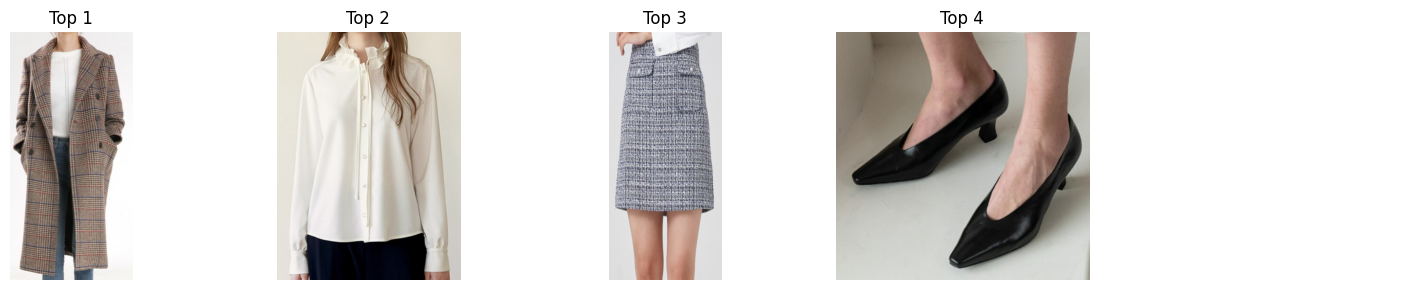

In [139]:
recommend_indices = []
ind=0
for feature in maje_style_features2:
    feature_reshaped = feature.reshape(1, -1)
    indices, indice_feature = sim2.get_sim(feature_reshaped, k=15)
    indice_filter = []

    for j in range(len(indices)):
        chk = cluster_names[kmeans.predict(indice_feature[j].reshape(1, -1))[0]]

        if categorize_item(chk) == categorize_item(categories[ind]):
            indice_filter.append(indices[j])
            break
    
    ind += 1
    
    recommend_indices.extend(indice_filter)
Dataset.show_images(recommend_indices)